In [1]:
import gdal
import numpy as np
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import torch
from glob import glob
import shapely
import random
from tqdm import tqdm
from collections import Counter
from pybob.GeoImg import GeoImg
import osr
from pybob.image_tools import create_mask_from_shapefile
import gc
import imageio
import time
import shutil

In [9]:
def to_str(l):
    ll=[]
    for i in l:
        ii=list(i)
        k=''
        for j in ii:
            k+='&'
            k+=str(j)
        ll.append(k[1:])
    return ll


In [655]:
import gdal
import numpy as np
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import torch
from glob import glob
import shapely
import random
from tqdm import tqdm
from collections import Counter
from pybob.GeoImg import GeoImg
import osr
from pybob.image_tools import create_mask_from_shapefile
import gc
import imageio
import time
import shutil



U_shps={'S':'/home/hk/python_script/Ukraine/data/UNOSAT/Sievierodonetsk_CDA_20220725/Sievierodoetsk_boundary.shp',
'R':'/home/hk/python_script/Ukraine/data/UNOSAT/Rubizhne_CDA_20220709/Rubizhne_boundary.shp',
'V':'/home/hk/python_script/Ukraine/data/UNOSAT/volnovakha/volnovakha.shp',
'ML':'/home/hk/python_script/Ukraine/data/UNOSAT/M_L/Mariupol_and_Livoberezhyny.shp'}
cities=U_shps.keys()   
U_patch_p={
    'S':'/data4/Ukraine_img/Sievierodoetsk/',
    'R':'/data4/Ukraine_img/Rubizhne/',
    'V':'/data4/Ukraine_img/volnovskha/',
    'ML':'/data4/Ukraine_img/M_and_L/'
    }    
U_patch_path={}
for city in cities:
    if city=='ML':
        fs=glob(U_patch_p[city]+'*areaall*.pth')
    else:
        fs=glob(U_patch_p[city]+'*.pth')
    U_patch_path[city]=fs







import geopandas as gpd
import torch
liveuamap_point=gpd.read_file('/data4/liveuamap/U_point_use_bomb_xy.shp')
s_all=torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/MSRV/train.pth')+torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/MSRV/val.pth')
use_patch_dict={}
for city in cities:
    use_patch_dict[city]={}
for i in range(len(s_all)):
    
    id=os.path.basename(s_all[i][0][0]).split('_')[2][:6]
    city=os.path.basename(s_all[i][0][0]).split('_')[0]
    if city in ['area1','area2','area3','area4','Azovstal']:
        city='ML'
    else:
        city=city[0]
        if city=='v':
            city='V'

    use_patch_dict[city][id]=s_all[i]
def to_str(l):
    ll=[]
    for i in l:
        ii=list(i)
        k=''
        for j in ii:
            k+='&'
            k+=str(j)
        ll.append(k[1:])
    return ll




x=list(liveuamap_point['patch_x'])
y=list(liveuamap_point['patch_y'])
c_key=[str(y[i]).zfill(3)+str(x[i]).zfill(3) for i in range(len(x))]
region=list(liveuamap_point['region'])
ids=list(liveuamap_point['id'])
pp=[]
for i in range(len(x)):
    try:
        p=use_patch_dict[region[i]][c_key[i]][0]
        pp.append([i for i in p if i is not None])
    except:
        liveuamap_point=liveuamap_point.drop(liveuamap_point[liveuamap_point['id']==ids[i]].index)
liveuamap_point['img_path']=to_str(pp)


dss=[]
for i in range(len(liveuamap_point)):
    pl=liveuamap_point.iloc[i]
    ps=pl['img_path'].split('&')
    ds=[j.split('_')[-2][:8] for j in ps]
    dss.append(ds)
liveuamap_point['img_dates']=to_str(dss)
liveuamap_point['is_interv']=[1]*len(liveuamap_point)  


for city in cities:
    k=liveuamap_point[liveuamap_point['region']==city]
    c_key=[str(k.iloc[i]['patch_y']).zfill(3)+str(k.iloc[i]['patch_x']).zfill(3) for i in range(len(k))]
    for i in c_key:
        try:
            del use_patch_dict[city][i]
        except:
            pass
import random
pathes=[]
kk=[]
cc=[]
for city in cities:
    k=liveuamap_point[liveuamap_point['region']==city]
    keys=list(use_patch_dict[city].keys())
    random.shuffle(keys)
    keys_use=keys
    kk+=keys_use
    cc+=[city]*len(keys_use)
    for i in keys_use:
        pathes.append([i for i in use_patch_dict[city][i][0] if i is not None])
x=[int(i[3:]) for i in kk]
y=[int(i[:3]) for i in kk]




ts=[]
for i in tqdm(pathes):
    tt=[]
    for j in i:
        tt.append(j.split('_')[-2][:8])
    ts.append(tt)
from shapely.geometry import Point
gpeo=[Point([0,0])]*len(pathes)

def to_str(l):
    ll=[]
    for i in l:
        ii=list(i)
        k=''
        for j in ii:
            k+='&'
            k+=str(j)
        ll.append(k[1:])
    return ll
nointervention_pd=gpd.GeoDataFrame.from_dict({'id':list(range(len(pathes))),
'time':[0]*len(pathes),
'timestamp':[0]*len(pathes),
'type':['none']*len(pathes),
'name':['none']*len(pathes),
'is_use':[1]*len(pathes),
'region':cc,
'lat':[0]*len(pathes),
'lon':[0]*len(pathes),
'patch_x':x,
'patch_y':y,
'geometry':gpeo,
'is_interv':[0]*len(pathes),
'img_path':to_str(pathes),
'img_dates':to_str(ts)
})
all_liveuamap=pd.concat([liveuamap_point,nointervention_pd])

100%|██████████| 40873/40873 [00:00<00:00, 178416.29it/s]


In [9]:
s_all=torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/MSRV/train.pth')+torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/MSRV/val.pth')
use_patch_dict={}
for city in cities:
    use_patch_dict[city]={}
for i in range(len(s_all)):
    
    id=os.path.basename(s_all[i][0][0]).split('_')[2][:6]
    city=os.path.basename(s_all[i][0][0]).split('_')[0]
    if city in ['area1','area2','area3','area4','Azovstal']:
        city='ML'
    else:
        city=city[0]
        if city=='v':
            city='V'

    use_patch_dict[city][id]=s_all[i]
samples=[]
region=list(all_liveuamap['region'])
pp=list(all_liveuamap['img_path'])
for i in range(len(all_liveuamap)):
    samples.append(use_patch_dict[region[i]][pp[i].split('&')[0].split('_')[-1][:6]])
torch.save(samples,'/home/hk/python_script/Ukraine/checkpoints/试一试_Umynet6mtc1v2_Ukrain_size6_MSRVall_effectweight_v3_multi-time_RandomDelandCopyv2_weight45_trainMSRV/samples.pth')

In [10]:
import sys
sys.path.append('..')
# from Ukraine.model.load_model import get_model
import loader
# from python_script.Ukraine.loader.loader import get_rebuiling_loader
import run
import warnings
import numpy as np
warnings.filterwarnings("ignore")
loaders={'train':loader.get_rebuiling_loader('/home/hk/python_script/Ukraine/checkpoints/试一试_Umynet6mtc1v2_Ukrain_size6_MSRVall_effectweight_v3_multi-time_RandomDelandCopyv2_weight45_trainMSRV/samples.pth',batch_size=1),
        'val':loader.get_rebuiling_loader('/home/hk/python_script/Ukraine/checkpoints/试一试_Umynet6mtc1v2_Ukrain_size6_MSRVall_effectweight_v3_multi-time_RandomDelandCopyv2_weight45_trainMSRV/samples.pth',batch_size=1)}

trainer=run.get_trainer()
trainer2=trainer(loaders)
trainer2.load_checkpoint()

0,1
================ (Sat Feb 18 21:43:34 2023) ================
{project_name:试一试_Umynet6mtc1v2_Ukrain_size6_MSRVall_effectweight_v3_multi-time_RandomDelandCopyv2_weight45_trainMSRV,
 root_dir:/home/hk/python_script/Ukraine/,
 dataset:
    {name:Udamagedv3,
     args:
        {size:6,
         city:MSRV,
         mode:all}
 transform_train:
    {to_tensor:True,
     hv_flip_together:True}
 transform_val:
    {to_tensor:True,
     hv_flip_together:False}
 loader:
    {name:Usize6multitime,
     mode:RandomDelandCopyv2,
     use_samples_percent:1,
     batch_size:128,
     num_workers:8,
     shuffle:False}
 model:
    {name:Umynet6mtc1v2,
     args:
        {n_class:2,
 train:
    {name:Umultitime,
     gpu_ids:[0, 1],
     lr:0.005,
     lr_policy:step,
     loadbestmodel_whenbackwateracc:[False, 10],
     step_size:20,
     gamma:0.5,
     momentum:0.5,
     w_decay:0.0005,
     max_epochs:100,
     loss:cross_entropy,
     load_pretrain:[False, 'SupCon1000v2', 'ckpt_epoch_1000.pth',

In [112]:
pre_results=[]
pre_results_softmax=[]
from torch import nn
for i,v in enumerate(loaders['val']):
    model=trainer2.model
    model.eval()
    if i%1000==0:
        print(i)

    vl=list(v[2][0].numpy())
    # print(i,list(v[2][0].numpy()))
    l=samples[i][1]
    ll=[k for k in l if k is not None]
    zeros_img_len=20-len(ll)
    lll=[1 if z=='p' else 0 for z in ll]+[-1]*zeros_img_len
    # print(i,[1 if z=='p' else 0 for z in ll]+[-1]*(20-len(ll)))
    for j in range(len(vl)):
        if vl[j]!=lll[j]:
            raise(f'{i} is error')
    model=trainer2.model
    img=[v[0].type(torch.FloatTensor).cuda(),
        v[1].type(torch.FloatTensor).cuda()]
    output=model(img)

    pp=torch.argmax(output,dim=2)[0].cpu().numpy()
    pre_result=torch.argmax(output,dim=2)[0].cpu().numpy()[:20-zeros_img_len]
    softmax_0 = nn.Softmax(dim=1)
    output_softmax=softmax_0(output[0])[:,1].cpu().detach().numpy()[:20-zeros_img_len]
    pre_results.append(pre_result)
    pre_results_softmax.append(output_softmax)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000


In [118]:
all_liveuamap['MTCF-PtNet']=to_str(pre_results)
all_liveuamap['MTCF-sm']=to_str(pre_results_softmax)

In [119]:
all_liveuamap

,id,time,timestamp,type,name,is_use,region,lat,lon,patch_x,patch_y,geometry,img_path,img_dates,is_interv,MTCF-PtNet,MTCF-sm
0,22399771,2022-02-28 20:33:00,1646051580,bomb-1,Russian troops shelled Severodonetsk causing w...,1,S,48.94505,38.50365,139,75,POINT (38.50365 48.94505),/ssd/hk/Ukraine_samples/samplesv2/samples_Siev...,20220319&20220324&20220329&20220408&20220423&2...,1,0&0&0&0&0&0&0&0&0&0,0.0005412354&4.9145823e-05&5.1388865e-06&9.006...
1,22400730,2022-03-02 20:32:00,1646224320,bomb-1,Russian army targeted childrengarden in Siever...,1,S,48.94447,38.48047,96,76,POINT (38.48047 48.94447),/ssd/hk/Ukraine_samples/samplesv2/samples_Siev...,20220319&20220324&20220329&20220408&20220423&2...,1,0&0&0&0&0&0&0&0&0&0&0,0.018250644&0.031897295&0.0026652275&0.0034209...
2,22405039,2022-03-10 20:35:00,1646915700,bomb-1,Fires after heavy shelling by Russian army tar...,1,S,48.94818,38.48788,110,69,POINT (38.48788 48.94818),/ssd/hk/Ukraine_samples/samplesv2/samples_Siev...,20220319&20220324&20220329&20220408&20220508&2...,1,0&0&0&0&0&0&0&0&0&0,0.00078607595&7.591272e-05&1.9761792e-05&2.433...
3,22406433,2022-03-13 15:53:00,1647157980,bomb-1,Russian army continues to shell Severodonetsk,1,S,48.94818,38.48788,110,69,POINT (38.48788 48.94818),/ssd/hk/Ukraine_samples/samplesv2/samples_Siev...,20220319&20220324&20220329&20220408&20220508&2...,1,0&0&0&0&0&0&0&0&0&0,0.00078607595&7.591272e-05&1.9761792e-05&2.433...
4,22406046,2022-03-12 20:57:00,1647089820,bomb-1,Heavy shelling triggered multiple fires in Sev...,1,S,48.94572,38.47904,93,74,POINT (38.47904 48.94572),/ssd/hk/Ukraine_samples/samplesv2/samples_Siev...,20220319&20220324&20220329&20220408&20220508&2...,1,0&0&0&0&0&0&0&0&0&0&0,0.00026156037&1.6930486e-05&4.8404468e-06&1.10...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40868,40868,0,0,none,none,1,ML,0.00000,0.00000,227,240,POINT (0.00000 0.00000),/ssd/hk/Ukraine_samples/samplesv2/samples_Azov...,20220319&20220324&20220329,0,0&0&0,0.00078936265&0.00030233976&0.00033408552
40869,40869,0,0,none,none,1,ML,0.00000,0.00000,331,186,POINT (0.00000 0.00000),/ssd/hk/Ukraine_samples/samplesv2/samples/area...,20220314&20220319&20220324&20220329,0,0&0&0&0,0.0070874533&0.0014050035&0.00026884605&0.0003...
40870,40870,0,0,none,none,1,ML,0.00000,0.00000,372,205,POINT (0.00000 0.00000),/ssd/hk/Ukraine_samples/samplesv2/samples/area...,20220314&20220319&20220324&20220329&20220503,0,0&0&0&0&0,0.18815432&0.2258087&0.07995765&0.019437589&0....
40871,40871,0,0,none,none,1,ML,0.00000,0.00000,322,169,POINT (0.00000 0.00000),/ssd/hk/Ukraine_samples/samplesv2/samples/area...,20220314&20220319&20220324&20220329,0,0&0&0&0,0.0012338291&0.0002176822&4.3543685e-05&0.0001...


In [121]:
cities=list(cities)

In [227]:
import time
def to_timestamp(t):
    if not len(t)==8:
        raise('time length error')
    t=f'{t[:4]}-{t[4:6]}-{t[6:]}'
    struct_time=time.strptime(t,'%Y-%m-%d')
    return time.mktime(struct_time)
def get_res(event,ts):
    for i in range(len(ts)):
        if ts[i]>event:
            break
    return [i*(-1) for i in list(range(1,len(ts[:i])+1)[::-1])]+list(range(1,len(ts[i:])+1))
did_pd_list=[]
for i in tqdm(range(len(all_liveuamap))):
    s=all_liveuamap.iloc[i]
    rs=[np.float(i) for i in s['MTCF-sm'].split('&')]
    rsc=[np.int(i) for i in s['MTCF-PtNet'].split('&')]
    regions=[cities.index(s['region'])]*len(rsc)
    events=[s['timestamp']]*len(rsc)
    ids=[s['id']]*len(rsc)
    intervs=[s['is_interv']]*len(rsc)

    ts=[to_timestamp(i) for i in s['img_dates'].split('&')]
    # if intervs[0]==0:
    #     res=[-99]*len(rsc)
    # else:
    #     res=get_res(events[0],ts)
    did_pd_list.append(pd.DataFrame.from_dict({'id':ids,
                                                'time':ts,
                                                'interv_time':events,
                                                # 'period_difference':res,
                                                'value':rs,
                                                'value_c':rsc,
                                                'is_interv':intervs,
                                                'region':regions
                                                }))
did_pd=pd.concat(did_pd_list)

100%|██████████| 40975/40975 [00:30<00:00, 1360.44it/s]


In [228]:
did_pd

,id,time,interv_time,value,value_c,is_interv,region
0,22399771,1.647619e+09,1646051580,0.000541,0,1,0
1,22399771,1.648051e+09,1646051580,0.000049,0,1,0
2,22399771,1.648483e+09,1646051580,0.000005,0,1,0
3,22399771,1.649347e+09,1646051580,0.000009,0,1,0
4,22399771,1.650643e+09,1646051580,0.000012,0,1,0
...,...,...,...,...,...,...,...
1,40871,1.647619e+09,0,0.000218,0,0,3
2,40871,1.648051e+09,0,0.000044,0,0,3
3,40871,1.648483e+09,0,0.000181,0,0,3
0,40872,1.645891e+09,0,0.011282,0,0,3


In [124]:
all_liveuamap.to_file('/data4/liveuamap/U_did_mt_c.shp')

In [237]:
did_pd['time_period']=[int(int(i)/1296000)-1269 for i in list(did_pd['time'])]
print(1)
did_pd['interv_time_period']=[int(int(i)/1296000)-1269 for i in list(did_pd['interv_time'])]
print(2)
did_pd['period_difference']=list(np.array(did_pd['time_period'])-np.array(did_pd['interv_time_period']))
print(3)
did_pd.loc[did_pd['is_interv']==0,'interv_time_period']=-99
did_pd.loc[did_pd['is_interv']==0,'period_difference']=-99
did_pd['id_t']=list(range(len(did_pd)))
did_pd=did_pd.set_index('id_t')
did_pd.to_stata('/data4/liveuamap/U_did_mt_c.dta')

1
2
3


In [238]:
did_pd

,id,time,interv_time,value,value_c,is_interv,region,time_period,interv_time_period,period_difference
id_t,,,,,,,,,,
0,22399771,1.647619e+09,1646051580,0.000541,0,1,0,2,1,1
1,22399771,1.648051e+09,1646051580,0.000049,0,1,0,2,1,1
2,22399771,1.648483e+09,1646051580,0.000005,0,1,0,2,1,1
3,22399771,1.649347e+09,1646051580,0.000009,0,1,0,3,1,2
4,22399771,1.650643e+09,1646051580,0.000012,0,1,0,4,1,3
...,...,...,...,...,...,...,...,...,...,...
287415,40871,1.647619e+09,0,0.000218,0,0,3,2,-99,-99
287416,40871,1.648051e+09,0,0.000044,0,0,3,2,-99,-99
287417,40871,1.648483e+09,0,0.000181,0,0,3,2,-99,-99


In [242]:
did_pd_noML=did_pd.drop(did_pd[did_pd['region']==3].index)

In [265]:
liveuamap_point2=gpd.read_file('/data4/liveuamap/U_point_use_bomb_xy.shp')

In [247]:
len(all_liveuamap2[all_liveuamap2['region']=='ML'])

50

In [248]:
len(all_liveuamap2[all_liveuamap2['region']=='S'])

42

In [249]:
len(all_liveuamap2[all_liveuamap2['region']=='V'])

1

In [250]:
len(all_liveuamap2[all_liveuamap2['region']=='R'])

20

<AxesSubplot:>

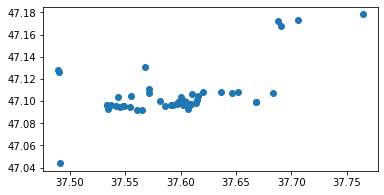

In [252]:
all_liveuamap2[all_liveuamap2['region']=='ML'].plot()

In [386]:
import geopandas as gpd
import rasterio
from glob import glob
inference=glob('/data4/Ukraine_img/M_and_L_inference/*_MRSV.tif')
inference.sort()
imgs=[]
for f in inference:
    img=rasterio.open(f).read(1)
    imgs.append(img)
cube=np.stack(imgs)

In [387]:
inference

['/data4/Ukraine_img/M_and_L_inference/20220227T082911_20220227T083303_T37TCN2_MRSV.tif',
 '/data4/Ukraine_img/M_and_L_inference/20220309T082801_20220309T083304_T37TCN2_MRSV.tif',
 '/data4/Ukraine_img/M_and_L_inference/20220314T082719_20220314T083610_T37TCN2_MRSV.tif',
 '/data4/Ukraine_img/M_and_L_inference/20220319T082651_20220319T083304_T37TCN2_MRSV.tif',
 '/data4/Ukraine_img/M_and_L_inference/20220324T082609_20220324T083426_T37TCN2_MRSV.tif',
 '/data4/Ukraine_img/M_and_L_inference/20220329T082601_20220329T083216_T37TCN2_MRSV.tif',
 '/data4/Ukraine_img/M_and_L_inference/20220403T082559_20220403T083553_T37TCN2_MRSV.tif',
 '/data4/Ukraine_img/M_and_L_inference/20220428T082611_20220428T083305_T37TCN2_MRSV.tif',
 '/data4/Ukraine_img/M_and_L_inference/20220503T082559_20220503T083512_T37TCN2_MRSV.tif',
 '/data4/Ukraine_img/M_and_L_inference/20220508T082611_20220508T083304_T37TCN2_MRSV.tif',
 '/data4/Ukraine_img/M_and_L_inference/20220523T082559_20220523T082946_T37TCN2_MRSV.tif',
 '/data4/U

In [605]:
liveuamap_point_ML=liveuamap_point2[liveuamap_point2['region']=='ML']

ll=[]
for i in range(len(liveuamap_point_ML)):
    x=liveuamap_point_ML.iloc[i]['patch_x']
    y=liveuamap_point_ML.iloc[i]['patch_y']
    ll.append([int(i) for i in list(cube[:,y,x])])
date_base=[os.path.basename(i)[:8] for i in inference]
ll2=[]
date2=[]
for l in ll:
    l2=[]
    d2=[]
    for i in range(len(l)):
        if l[i]==-1:
            pass
        elif l[i]==0:
            l2.append(0)
            d2.append(date_base[i])
        else:
            l2.append(1)
            d2.append(date_base[i])
    ll2.append(l2)
    date2.append(d2)
liveuamap_point_ML['img_dates']=to_str(date2)
liveuamap_point_ML['MTCF-PtNet']=to_str(ll2)
liveuamap_point_ML['is_interv']=[1]*len(liveuamap_point_ML)


In [606]:
mask=cube[9].copy()
mask[mask>=0]=1
mask[mask==-1]=0


ll=[]
coords=[]
for y in range(cube.shape[1]):
    for x in range(cube.shape[2]):
        if mask[y,x]==0:
            pass
        else:
            ll.append([int(i) for i in list(cube[:,y,x])])
            coords.append([x,y])
date_base=[os.path.basename(i)[:8] for i in inference]
ll2=[]
date2=[]
for l in ll:
    l2=[]
    d2=[]
    for i in range(len(l)):
        if l[i]==-1:
            pass
        elif l[i]==0:
            l2.append(0)
            d2.append(date_base[i])
        else:
            l2.append(1)
            d2.append(date_base[i])
    ll2.append(l2)
    date2.append(d2)



from shapely.geometry import Point
gpeo=[Point([0,0])]*len(ll2)
nointervention_pd_ML=gpd.GeoDataFrame.from_dict({'id':list(range(len(ll2))),
'time':[0]*len(ll2),
'timestamp':[0]*len(ll2),
'type':['none']*len(ll2),
'name':['none']*len(ll2),
'is_use':[1]*len(ll2),
'region':['ML']*len(ll2),
'lat':[0]*len(ll2),
'lon':[0]*len(ll2),
'patch_x':[i[0] for i in coords],
'patch_y':[i[1] for i in coords],
'geometry':gpeo,
'is_interv':[0]*len(ll2),
'MTCF-PtNet':to_str(ll2),
'img_dates':to_str(date2)
})
all_liveuamap_ML=pd.concat([liveuamap_point_ML,nointervention_pd_ML])

In [397]:
liveuamap_point_ML

,id,time,timestamp,type,name,is_use,region,lat,lon,patch_x,patch_y,geometry,img_dates,MTCF-PtNet,is_interv
63,22413971,2022-03-26 03:54:00,1648238040,bomb-2,Clashes continue in Mariupol',1,ML,47.108120,37.636590,323,212,POINT (37.63659 47.10812),20220309&20220314&20220319&20220324&20220329&2...,0&0&0&0&0&0&0&0&0&0&0,1
64,22422939,2022-04-09 23:11:05,1649517065,bomb-2,Mariupol: Accurate mortar fire by Azov targeti...,1,ML,47.043810,37.491360,53,331,POINT (37.49136 47.04381),20220314&20220319&20220324&20220329&20220403&2...,0&0&0&0&0&0&0&0&1&1&1&1,1
65,22397299,2022-02-24 11:38:00,1645673880,bomb-1,Massive explosions hit the Ukrainian port city...,1,ML,47.107390,37.646030,340,213,POINT (37.64603 47.10739),20220309&20220314&20220319&20220324&20220329&2...,0&0&0&0&0&0&0&1&1&1&0&0,1
66,22397228,2022-02-24 09:06:00,1645664760,bomb-1,Clashes audible this night in Mariupol,1,ML,47.107250,37.683450,410,214,POINT (37.68345 47.10725),20220314&20220319&20220324&20220503&20220508&2...,0&0&0&0&0&0&0&0&0&0,1
67,22398034,2022-02-25 20:15:00,1645791300,bomb-1,Mayor of Mariupol: clashes with Russian army n...,1,ML,47.178280,37.764130,559,82,POINT (37.76413 47.17828),20220314&20220319&20220324&20220503&20220508&2...,0&0&0&0&0&0&0&0,1
68,22398656,2022-02-26 22:09:00,1645884540,bomb-1,Multiple dead among civilian population as res...,1,ML,47.171830,37.687740,418,94,POINT (37.68774 47.17183),20220314&20220319&20220324&20220329&20220508&2...,0&0&0&0&0&0&0&0&0,1
69,22398180,2022-02-26 03:00:00,1645815600,bomb-1,In Mariupol shelling targeted school and high-...,1,ML,47.099120,37.667870,381,229,POINT (37.66787 47.09912),20220227&20220314&20220319&20220324&20220329&2...,0&0&0&0&0&0&0&1&1&1&1&1,1
70,22398177,2022-02-26 02:53:00,1645815180,bomb-1,Russian troops shelling Mariupol with MLRS GRAD,1,ML,47.099350,37.668290,381,228,POINT (37.66829 47.09935),20220314&20220319&20220324&20220329&20220503&2...,0&0&0&0&0&0&1&1&1&1&1,1
71,22399609,2022-02-28 15:27:00,1646033220,bomb-1,Russian aviation targeted Sartana,1,ML,47.167310,37.690830,423,102,POINT (37.69083 47.16731),20220319&20220324&20220329&20220508&20220528&2...,0&0&0&0&0&0&0&0,1
72,22400538,2022-03-02 14:19:00,1646201940,bomb-1,"On the morning of March 2, the Russian army sh...",1,ML,47.110910,37.571870,203,207,POINT (37.57187 47.11091),20220314&20220319&20220324&20220329&20220503&2...,0&0&0&0&0&0&0&0&1&1&1&1,1


In [400]:
all_liveuamap_ML

,id,time,timestamp,type,name,is_use,region,lat,lon,patch_x,patch_y,geometry,img_dates,MTCF-PtNet,is_interv
63,22413971,2022-03-26 03:54:00,1648238040,bomb-2,Clashes continue in Mariupol',1,ML,47.10812,37.63659,323,212,POINT (37.63659 47.10812),20220309&20220314&20220319&20220324&20220329&2...,0&0&0&0&0&0&0&0&0&0&0,1
64,22422939,2022-04-09 23:11:05,1649517065,bomb-2,Mariupol: Accurate mortar fire by Azov targeti...,1,ML,47.04381,37.49136,53,331,POINT (37.49136 47.04381),20220314&20220319&20220324&20220329&20220403&2...,0&0&0&0&0&0&0&0&1&1&1&1,1
65,22397299,2022-02-24 11:38:00,1645673880,bomb-1,Massive explosions hit the Ukrainian port city...,1,ML,47.10739,37.64603,340,213,POINT (37.64603 47.10739),20220309&20220314&20220319&20220324&20220329&2...,0&0&0&0&0&0&0&1&1&1&0&0,1
66,22397228,2022-02-24 09:06:00,1645664760,bomb-1,Clashes audible this night in Mariupol,1,ML,47.10725,37.68345,410,214,POINT (37.68345 47.10725),20220314&20220319&20220324&20220503&20220508&2...,0&0&0&0&0&0&0&0&0&0,1
67,22398034,2022-02-25 20:15:00,1645791300,bomb-1,Mayor of Mariupol: clashes with Russian army n...,1,ML,47.17828,37.76413,559,82,POINT (37.76413 47.17828),20220314&20220319&20220324&20220503&20220508&2...,0&0&0&0&0&0&0&0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93669,93669,0,0,none,none,1,ML,0.00000,0.00000,16,364,POINT (0.00000 0.00000),20220314&20220319&20220324&20220329&20220403&2...,0&0&0&0&0&0&0&0&0&1&1&1,0
93670,93670,0,0,none,none,1,ML,0.00000,0.00000,17,364,POINT (0.00000 0.00000),20220314&20220319&20220324&20220329&20220403&2...,0&0&0&0&0&0&0&0&0&1&1&1,0
93671,93671,0,0,none,none,1,ML,0.00000,0.00000,18,364,POINT (0.00000 0.00000),20220314&20220319&20220324&20220329&20220403&2...,0&0&0&0&0&0&0&0&0&0&0,0
93672,93672,0,0,none,none,1,ML,0.00000,0.00000,19,364,POINT (0.00000 0.00000),20220314&20220319&20220324&20220329&20220403&2...,0&0&0&0&0&0&0&0&0&0&0,0


In [444]:
x

[154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154]

In [568]:
import time
def to_timestamp(t):
    if not len(t)==8:
        raise('time length error')
    t=f'{t[:4]}-{t[4:6]}-{t[6:]}'
    struct_time=time.strptime(t,'%Y-%m-%d')
    return time.mktime(struct_time)
def get_res(event,ts):
    for i in range(len(ts)):
        if ts[i]>event:
            break
    return [i*(-1) for i in list(range(1,len(ts[:i])+1)[::-1])]+list(range(1,len(ts[i:])+1))
did_pd_list=[]
for i in tqdm(range(len(all_liveuamap_ML))):
    s=all_liveuamap_ML.iloc[i]
    rsc=[np.int(i) for i in s['MTCF-PtNet'].split('&')]
    x=[np.int(i) for i in [s['patch_x']]*len(s['MTCF-PtNet'].split('&'))]
    y=[np.int(i) for i in [s['patch_y']]*len(s['MTCF-PtNet'].split('&'))]
    regions=[cities.index(s['region'])]*len(rsc)
    events=[s['timestamp']]*len(rsc)
    ids=[s['id']]*len(rsc)
    intervs=[s['is_interv']]*len(rsc)

    ts=[to_timestamp(i) for i in s['img_dates'].split('&')]
    # if intervs[0]==0:
    #     res=[-99]*len(rsc)
    # else:
    #     res=get_res(events[0],ts)
    did_pd_list.append(pd.DataFrame.from_dict({'id':ids,
                                                'time':ts,
                                                'interv_time':events,
                                                # 'period_difference':res,
                                                'value_c':rsc,
                                                'is_interv':intervs,
                                                'region':regions,
                                                'x':x,
                                                'y':y
                                                }))
did_pd_ML=pd.concat(did_pd_list)

100%|██████████| 93724/93724 [02:11<00:00, 710.35it/s]


In [600]:
all_liveuamap_ML2.to_file('/data4/liveuamap/U_did_mt_c_ML2.shp')

In [454]:
z=3600*24*20
print(z)
np.array([int(int(i)/z) for i in list(did_pd_ML['time'])]).min()

1728000


952

In [569]:
did_pd_ML['time_period']=[int(int(i)/1728000)-952 for i in list(did_pd_ML['time'])]
print(1)
did_pd_ML['interv_time_period']=[int(int(i)/1728000)-952 for i in list(did_pd_ML['interv_time'])]
print(2)
did_pd_ML['period_difference']=list(np.array(did_pd_ML['time_period'])-np.array(did_pd_ML['interv_time_period']))
print(3)
did_pd_ML.loc[did_pd_ML['is_interv']==0,'interv_time_period']=-99
did_pd_ML.loc[did_pd_ML['is_interv']==0,'period_difference']=-99
did_pd_ML['id_t']=list(range(len(did_pd_ML)))
did_pd_ML=did_pd_ML.set_index('id_t')
# did_pd_ML.to_stata('/data4/liveuamap/U_did_mt_c_ML2.dta')
for i in range(-10,11):
    v=list(did_pd_ML[(did_pd_ML['is_interv']==1)&(did_pd_ML['period_difference']==i)]['value_c'])
    print(i,np.array(v).sum(),len(v),np.array(v).sum()/len(v))

1
2
3


In [456]:
did_pd_ML

,id,time,interv_time,value_c,is_interv,region,x,y,time_period,interv_time_period,period_difference
id_t,,,,,,,,,,,
0,22413971,1.646755e+09,1648238040,0,1,3,323,212,0,1,-1
1,22413971,1.647187e+09,1648238040,0,1,3,323,212,1,1,0
2,22413971,1.647619e+09,1648238040,0,1,3,323,212,1,1,0
3,22413971,1.648051e+09,1648238040,0,1,3,323,212,1,1,0
4,22413971,1.648483e+09,1648238040,0,1,3,323,212,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
963374,93673,1.651939e+09,0,0,0,3,18,365,3,-99,-99
963375,93673,1.653667e+09,0,0,0,3,18,365,4,-99,-99
963376,93673,1.654099e+09,0,0,0,3,18,365,5,-99,-99


In [570]:
for i in range(-10,11):
    v=list(did_pd_ML[(did_pd_ML['is_interv']==1)&(did_pd_ML['period_difference']==i)]['value_c'])
    print(i,np.array(v).sum(),len(v),np.array(v).sum()/len(v))

-10 0.0 0 nan
-9 0.0 0 nan
-8 0.0 0 nan
-7 0.0 0 nan
-6 0.0 0 nan
-5 0.0 0 nan
-4 0 2 0.0
-3 0 18 0.0
-2 0 53 0.0
-1 0 24 0.0
0 0 84 0.0
1 1 91 0.01098901098901099
2 13 76 0.17105263157894737
3 5 61 0.08196721311475409
4 15 75 0.2
5 15 54 0.2777777777777778
6 1 3 0.3333333333333333
7 0.0 0 nan
8 0.0 0 nan
9 0.0 0 nan
10 0.0 0 nan


68 163


In [799]:
import gdal
import numpy as np
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import torch
from glob import glob
import shapely
import random
from tqdm import tqdm
from collections import Counter
from pybob.GeoImg import GeoImg
import osr
from pybob.image_tools import create_mask_from_shapefile
import gc
import imageio
import time
import shutil
import torch


U_shps={'S':'/home/hk/python_script/Ukraine/data/UNOSAT/Sievierodonetsk_CDA_20220725/Sievierodoetsk_boundary.shp',
'R':'/home/hk/python_script/Ukraine/data/UNOSAT/Rubizhne_CDA_20220709/Rubizhne_boundary.shp',
'V':'/home/hk/python_script/Ukraine/data/UNOSAT/volnovakha/volnovakha.shp',
'ML':'/home/hk/python_script/Ukraine/data/UNOSAT/M_L/Mariupol_and_Livoberezhyny.shp'}
livepoint_path='/data4/liveuamap/U_point_use_bomb_xy.shp'
cities=U_shps.keys()   
U_patch_p={
    'S':'/data4/Ukraine_img/Sievierodoetsk/',
    'R':'/data4/Ukraine_img/Rubizhne/',
    'V':'/data4/Ukraine_img/volnovskha/',
    'ML':'/data4/Ukraine_img/M_and_L/'
    }    
U_patch_path={}
for city in cities:
    if city=='ML':
        fs=glob(U_patch_p[city]+'*areaall*.pth')
    else:
        fs=glob(U_patch_p[city]+'*.pth')
    U_patch_path[city]=fs


def to_str(l):
    ll=[]
    for i in l:
        ii=list(i)
        k=''
        for j in ii:
            k+='&'
            k+=str(j)
        ll.append(k[1:])
    return ll

def to_timestamp(t):
    if not len(t)==8:
        raise('time length error')
    t=f'{t[:4]}-{t[4:6]}-{t[6:]}'
    struct_time=time.strptime(t,'%Y-%m-%d')
    return time.mktime(struct_time)



#读取爆炸数据
liveuamap_point=gpd.read_file(livepoint_path)
liveuamap_point_ML=liveuamap_point[liveuamap_point['region']=='ML']


#加载预测结果cube
inference=glob('/data4/Ukraine_img/M_and_L_inference/*MRSV.tif')
inference.sort()
imgs=[]
for f in inference:
    img=rasterio.open(f).read(1)
    imgs.append(img)
cube=np.stack(imgs)
mask=cube[9].copy()
mask[mask>=0]=1
mask[mask==-1]=0


for i in range(12,18):
    k=cube[11].copy()
    k[cube[i]==-1]=-1
    cube[i]=k

#读取预测值和对应日期
ll=[]
for i in range(len(liveuamap_point_ML)):
    x=liveuamap_point_ML.iloc[i]['patch_x']
    y=liveuamap_point_ML.iloc[i]['patch_y']
    ll.append([int(i) for i in list(cube[:,y,x])])
date_base=[os.path.basename(i)[:8] for i in inference]
ll2=[]
date2=[]
for l in ll:
    l2=[]
    d2=[]
    for i in range(len(l)):
        if l[i]==-1:
            pass
        elif l[i]==0:
            l2.append(0)
            d2.append(date_base[i])
        else:
            l2.append(1)
            d2.append(date_base[i])
    ll2.append(l2)
    date2.append(d2)
liveuamap_point_ML['img_dates']=to_str(date2)
liveuamap_point_ML['MTCF-PtNet']=to_str(ll2)
liveuamap_point_ML['is_interv']=[1]*len(liveuamap_point_ML)



#生成对照组


#遍历点
ll=[]
coords=[]
for y in range(cube.shape[1]):
    for x in range(cube.shape[2]):
        if mask[y,x]==0:
            pass
        else:
            ll.append([int(i) for i in list(cube[:,y,x])])
            coords.append([x,y])


#读取预测值和对应日期
date_base=[os.path.basename(i)[:8] for i in inference]
ll2=[]
date2=[]
for l in ll:
    l2=[]
    d2=[]
    for i in range(len(l)):
        if l[i]==-1:
            pass
        elif l[i]==0:
            l2.append(0)
            d2.append(date_base[i])
        else:
            l2.append(1)
            d2.append(date_base[i])
    ll2.append(l2)
    date2.append(d2)


# 生成对照组pd
from shapely.geometry import Point
gpeo=[Point([0,0])]*len(ll2)
nointervention_pd_ML=gpd.GeoDataFrame.from_dict({'id':list(range(len(ll2))),
'time':[0]*len(ll2),
'timestamp':[0]*len(ll2),
'type':['none']*len(ll2),
'name':['none']*len(ll2),
'is_use':[1]*len(ll2),
'region':['ML']*len(ll2),
'lat':[0]*len(ll2),
'lon':[0]*len(ll2),
'patch_x':[i[0] for i in coords],
'patch_y':[i[1] for i in coords],
'geometry':gpeo,
'is_interv':[0]*len(ll2),
'MTCF-PtNet':to_str(ll2),
'img_dates':to_str(date2)
})

#合并实验组和对照组
all_liveuamap_ML=pd.concat([liveuamap_point_ML,nointervention_pd_ML])

In [764]:
all_liveuamap_ML

,id,time,timestamp,type,name,is_use,region,lat,lon,patch_x,patch_y,geometry,img_dates,MTCF-PtNet,is_interv
63,22413971,2022-03-26 03:54:00,1648238040,bomb-2,Clashes continue in Mariupol',1,ML,47.10812,37.63659,325,211,POINT (37.63659 47.10812),20220309&20220314&20220319&20220324&20220329&2...,0&0&0&0&0&0&0&0&0&0&0,1
64,22422939,2022-04-09 23:11:05,1649517065,bomb-2,Mariupol: Accurate mortar fire by Azov targeti...,1,ML,47.04381,37.49136,55,330,POINT (37.49136 47.04381),20220314&20220319&20220324&20220329&20220403&2...,0&0&0&0&0&0&0&0&0&0&0&0,1
65,22397299,2022-02-24 11:38:00,1645673880,bomb-1,Massive explosions hit the Ukrainian port city...,1,ML,47.10739,37.64603,342,212,POINT (37.64603 47.10739),20220309&20220314&20220319&20220324&20220329&2...,0&0&0&0&0&0&0&0&0&0&0&0,1
66,22397228,2022-02-24 09:06:00,1645664760,bomb-1,Clashes audible this night in Mariupol,1,ML,47.10725,37.68345,412,213,POINT (37.68345 47.10725),20220314&20220319&20220324&20220503&20220508&2...,0&0&0&0&0&0&0&0&0&0,1
67,22398034,2022-02-25 20:15:00,1645791300,bomb-1,Mayor of Mariupol: clashes with Russian army n...,1,ML,47.17828,37.76413,561,81,POINT (37.76413 47.17828),20220314&20220319&20220324&20220503&20220508&2...,0&0&0&0&0&0&0&0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93669,93669,0,0,none,none,1,ML,0.00000,0.00000,16,364,POINT (0.00000 0.00000),20220314&20220319&20220324&20220329&20220403&2...,0&0&0&0&0&0&0&0&0&0&0&0,0
93670,93670,0,0,none,none,1,ML,0.00000,0.00000,17,364,POINT (0.00000 0.00000),20220314&20220319&20220324&20220329&20220403&2...,0&0&0&0&0&0&0&0&0&0&0&0,0
93671,93671,0,0,none,none,1,ML,0.00000,0.00000,18,364,POINT (0.00000 0.00000),20220314&20220319&20220324&20220329&20220403&2...,0&0&0&0&0&0&0&0&0&0&0,0
93672,93672,0,0,none,none,1,ML,0.00000,0.00000,19,364,POINT (0.00000 0.00000),20220314&20220319&20220324&20220329&20220403&2...,0&0&0&0&0&0&0&0&0&0&0,0


In [786]:
#生成面板数据
did_pd_list=[]
for i in tqdm(range(len(all_liveuamap_ML))):
    s=all_liveuamap_ML.iloc[i]
    rsc=[np.int(i) for i in s['MTCF-PtNet'].split('&')]
    x=[np.int(i) for i in [s['patch_x']]*len(s['MTCF-PtNet'].split('&'))]
    y=[np.int(i) for i in [s['patch_y']]*len(s['MTCF-PtNet'].split('&'))]
    # regions=[cities.index(s['region'])]*len(rsc)
    events=[s['timestamp']]*len(rsc)
    ids=[s['id']]*len(rsc)
    intervs=[s['is_interv']]*len(rsc)

    ts=[to_timestamp(i) for i in s['img_dates'].split('&')]
    # if intervs[0]==0:
    #     res=[-99]*len(rsc)
    # else:
    #     res=get_res(events[0],ts)
    did_pd_list.append(pd.DataFrame.from_dict({'id':ids,
                                                'time':ts,
                                                'interv_time':events,
                                                # 'period_difference':res,
                                                'value_c':rsc,
                                                'is_interv':intervs,
                                                # 'region':regions,
                                                'x':x,
                                                'y':y
                                                }))

#分割时间段和期数差
did_pd_ML=pd.concat(did_pd_list)
did_pd_ML['time_period']=[int(int(i)/1728000)-952 for i in list(did_pd_ML['time'])]
print(1)
did_pd_ML['interv_time_period']=[int(int(i)/1728000)-952 for i in list(did_pd_ML['interv_time'])]
print(2)
did_pd_ML['period_difference']=list(np.array(did_pd_ML['time_period'])-np.array(did_pd_ML['interv_time_period']))
print(3)
did_pd_ML.loc[did_pd_ML['is_interv']==0,'interv_time_period']=-99
did_pd_ML.loc[did_pd_ML['is_interv']==0,'period_difference']=-99
did_pd_ML['id_t']=list(range(len(did_pd_ML)))
did_pd_ML=did_pd_ML.set_index('id_t')
# did_pd_ML.to_stata('/data4/liveuamap/U_did_mt_c_ML2.dta')





#查看期数差的分布
for i in range(-10,11):
    v=list(did_pd_ML[(did_pd_ML['is_interv']==1)&(did_pd_ML['period_difference']==i)]['value_c'])
    print(i,np.array(v).sum(),len(v),np.array(v).sum()/len(v))

100%|██████████| 93724/93724 [02:05<00:00, 746.99it/s]


1
2
3
-10 0.0 0 nan
-9 0.0 0 nan
-8 0.0 0 nan
-7 0.0 0 nan
-6 0.0 0 nan
-5 0.0 0 nan
-4 0 2 0.0
-3 0 18 0.0
-2 0 53 0.0
-1 0 24 0.0
0 0 84 0.0
1 1 91 0.01098901098901099
2 4 76 0.05263157894736842
3 0 61 0.0
4 0 75 0.0
5 0 54 0.0
6 0 3 0.0
7 0.0 0 nan
8 0.0 0 nan
9 0.0 0 nan
10 0.0 0 nan


In [800]:

#计算最佳偏移量
L1=did_pd_ML[(did_pd_ML['is_interv']==1)&(did_pd_ML['period_difference']==1)]
L2=did_pd_ML[(did_pd_ML['is_interv']==1)&(did_pd_ML['period_difference']==2)]
L1id=list(L1['id'])
L2id=list(L2['id'])
ids=list(set(L1id+L2id))
result={}
for id in ids:
    ss=did_pd_ML[(did_pd_ML['is_interv']==1)&(did_pd_ML['period_difference']>=1)&(did_pd_ML['id']==id)]
    # ss=did_pd_ML[(did_pd_ML['is_interv']==1)&(did_pd_ML['period_difference']>=1)&(did_pd_ML['id']==id)]
    # ss=ss[ss['period_difference']<=2]
    result[id]=[]
    for x_offset2 in range(-3,4):
        for y_offset2 in range(-3,4):
            k=[]
            for i in range(len(ss)):

                s=ss.iloc[i]
                x=int(s['x'])+x_offset2
                y=int(s['y'])+y_offset2
                date=datetime.fromtimestamp(s['time']).strftime('%Y%m%d')
                date_index=date_base.index(date)
                vc=int(cube[date_index,y,x])
                if vc!=-1:
                    k.append(vc)
            result[id].append([x_offset2,y_offset2,np.array(k).sum(),len(k)])
n=0
nn=0
offset={}
for k in result.keys():
    l=result[k]
    random.shuffle(l)
    mx=[j[2] for j in l]
    i=mx.index(np.array(mx).max())
    le=l[i][3]
    n+=l[i][2]
    nn+=l[i][3]
    offset[k]=[l[i][0],l[i][1]]
    # print(k,l[i][2],l[i][3])
print(n,nn)


161 350


In [801]:
#使用偏移
offset_xs=[]
offset_ys=[]
for i in range(len(liveuamap_point_ML)):
    id=liveuamap_point_ML.iloc[i]['id']
    offset_key=list(offset.keys())
    random.shuffle(offset_key)
    offset_key=offset_key[:int(len(offset_key)/2)]
    if id in offset_key:
        offset_xs.append(offset[id][0])
        offset_ys.append(offset[id][1])
    else:
        offset_xs.append(0)
        offset_ys.append(0)
x=list(liveuamap_point_ML['patch_x'])   
y=list(liveuamap_point_ML['patch_y'])   
x_after_offset=list(np.array(x)+np.array(offset_xs))
y_after_offset=list(np.array(y)+np.array(offset_ys))
liveuamap_point_ML['patch_x']=x_after_offset
liveuamap_point_ML['patch_y']=y_after_offset
liveuamap_point_ML['offset_x']=offset_xs
liveuamap_point_ML['offset_y']=offset_ys
nointervention_pd_ML['offset_x']=[0]*len(nointervention_pd_ML)
nointervention_pd_ML['offset_y']=[0]*len(nointervention_pd_ML)


#重新提取预测值
ll=[]
for i in range(len(liveuamap_point_ML)):
    x=liveuamap_point_ML.iloc[i]['patch_x']
    y=liveuamap_point_ML.iloc[i]['patch_y']
    ll.append([int(i) for i in list(cube[:,y,x])])
date_base=[os.path.basename(i)[:8] for i in inference]
ll2=[]
date2=[]
for l in ll:
    l2=[]
    d2=[]
    for i in range(len(l)):
        if l[i]==-1:
            pass
        elif l[i]==0:
            l2.append(0)
            d2.append(date_base[i])
        else:
            l2.append(1)
            d2.append(date_base[i])
    ll2.append(l2)
    date2.append(d2)
liveuamap_point_ML['img_dates']=to_str(date2)
liveuamap_point_ML['MTCF-PtNet']=to_str(ll2)
liveuamap_point_ML['is_interv']=[1]*len(liveuamap_point_ML)

In [802]:
#去除对照组重复id
print(len(nointervention_pd_ML))
# ii_nouse=[]
for i in range(len(liveuamap_point_ML)):
    x=int(liveuamap_point_ML.iloc[i]['patch_x'])
    y=int(liveuamap_point_ML.iloc[i]['patch_y'])
    nointervention_pd_ML=nointervention_pd_ML.drop(nointervention_pd_ML[(nointervention_pd_ML['patch_x']==x)&(nointervention_pd_ML['patch_y']==y)].index)
# for i in ii_nouse:
#     nointervention_pd_ML=nointervention_pd_ML.drop(i)
print(len(nointervention_pd_ML))

93674
93625


In [803]:
liveuamap_point_ML

,id,time,timestamp,type,name,is_use,region,lat,lon,patch_x,patch_y,geometry,img_dates,MTCF-PtNet,is_interv,offset_x,offset_y
63,22413971,2022-03-26 03:54:00,1648238040,bomb-2,Clashes continue in Mariupol',1,ML,47.108120,37.636590,324,208,POINT (37.63659 47.10812),20220309&20220314&20220319&20220324&20220329&2...,0&0&0&0&0&0&0&1&1&1&1&1,1,-1,-3
64,22422939,2022-04-09 23:11:05,1649517065,bomb-2,Mariupol: Accurate mortar fire by Azov targeti...,1,ML,47.043810,37.491360,55,330,POINT (37.49136 47.04381),20220314&20220319&20220324&20220329&20220403&2...,0&0&0&0&0&0&0&0&0&0&0&0,1,0,0
65,22397299,2022-02-24 11:38:00,1645673880,bomb-1,Massive explosions hit the Ukrainian port city...,1,ML,47.107390,37.646030,339,210,POINT (37.64603 47.10739),20220309&20220314&20220319&20220324&20220329&2...,0&0&0&0&0&0&0&1&1&1&1&1,1,-3,-2
66,22397228,2022-02-24 09:06:00,1645664760,bomb-1,Clashes audible this night in Mariupol,1,ML,47.107250,37.683450,414,211,POINT (37.68345 47.10725),20220314&20220319&20220324&20220503&20220508&2...,0&0&0&0&0&0&0&0&0&0,1,2,-2
67,22398034,2022-02-25 20:15:00,1645791300,bomb-1,Mayor of Mariupol: clashes with Russian army n...,1,ML,47.178280,37.764130,561,80,POINT (37.76413 47.17828),20220314&20220319&20220324&20220503&20220508&2...,0&0&0&0&0&0&0&0&0,1,0,-1
68,22398656,2022-02-26 22:09:00,1645884540,bomb-1,Multiple dead among civilian population as res...,1,ML,47.171830,37.687740,420,93,POINT (37.68774 47.17183),20220314&20220319&20220324&20220329&20220508&2...,0&0&0&0&0&0&0&0&0,1,0,0
69,22398180,2022-02-26 03:00:00,1645815600,bomb-1,In Mariupol shelling targeted school and high-...,1,ML,47.099120,37.667870,381,226,POINT (37.66787 47.09912),20220314&20220319&20220324&20220329&20220503&2...,0&0&0&0&0&1&1&1&1&1&1,1,-2,-2
70,22398177,2022-02-26 02:53:00,1645815180,bomb-1,Russian troops shelling Mariupol with MLRS GRAD,1,ML,47.099350,37.668290,383,227,POINT (37.66829 47.09935),20220314&20220319&20220324&20220329&20220503&2...,0&0&0&0&0&0&0&0&0&0&0,1,0,0
71,22399609,2022-02-28 15:27:00,1646033220,bomb-1,Russian aviation targeted Sartana,1,ML,47.167310,37.690830,427,99,POINT (37.69083 47.16731),20220319&20220324&20220329&20220508&20220528&2...,0&0&0&0&1&1&1&1,1,2,-2
72,22400538,2022-03-02 14:19:00,1646201940,bomb-1,"On the morning of March 2, the Russian army sh...",1,ML,47.110910,37.571870,203,204,POINT (37.57187 47.11091),20220314&20220319&20220324&20220329&20220503&2...,0&0&0&0&0&0&1&1&1&1&1&1,1,-2,-2


In [804]:
#重新生成面板
all_liveuamap_ML2=pd.concat([liveuamap_point_ML,nointervention_pd_ML])
import time
def to_timestamp(t):
    if not len(t)==8:
        raise('time length error')
    t=f'{t[:4]}-{t[4:6]}-{t[6:]}'
    struct_time=time.strptime(t,'%Y-%m-%d')
    return time.mktime(struct_time)
def get_res(event,ts):
    for i in range(len(ts)):
        if ts[i]>event:
            break
    return [i*(-1) for i in list(range(1,len(ts[:i])+1)[::-1])]+list(range(1,len(ts[i:])+1))
did_pd_list=[]
for i in tqdm(range(len(all_liveuamap_ML2))):
    s=all_liveuamap_ML2.iloc[i]
    rsc=[np.int(i) for i in s['MTCF-PtNet'].split('&')]
    x=[np.int(i) for i in [s['patch_x']]*len(s['MTCF-PtNet'].split('&'))]
    y=[np.int(i) for i in [s['patch_y']]*len(s['MTCF-PtNet'].split('&'))]
    events=[s['timestamp']]*len(rsc)
    ids=[s['id']]*len(rsc)
    intervs=[s['is_interv']]*len(rsc)

    ts=[to_timestamp(i) for i in s['img_dates'].split('&')]
    # if intervs[0]==0:
    #     res=[-99]*len(rsc)
    # else:
    #     res=get_res(events[0],ts)
    did_pd_list.append(pd.DataFrame.from_dict({'id':ids,
                                                'time':ts,
                                                'interv_time':events,
                                                # 'period_difference':res,
                                                'value_c':rsc,
                                                'is_interv':intervs,
                                                'x':x,
                                                'y':y
                                                }))
did_pd_ML2=pd.concat(did_pd_list)

100%|██████████| 93675/93675 [02:04<00:00, 750.33it/s]


In [805]:
did_pd_ML2['time_period']=[int(int(i)/1728000)-952 for i in list(did_pd_ML2['time'])]
print(1)
did_pd_ML2['interv_time_period']=[int(int(i)/1728000)-952 for i in list(did_pd_ML2['interv_time'])]
print(2)
did_pd_ML2['period_difference']=list(np.array(did_pd_ML2['time_period'])-np.array(did_pd_ML2['interv_time_period']))
print(3)
did_pd_ML2.loc[did_pd_ML2['is_interv']==0,'interv_time_period']=-99
did_pd_ML2.loc[did_pd_ML2['is_interv']==0,'period_difference']=-99
did_pd_ML2['id_t']=list(range(len(did_pd_ML2)))
did_pd_ML2=did_pd_ML2.set_index('id_t')
did_pd_ML2.to_stata('/data4/liveuamap/U_did_mt_c_ML_25offsetpall_newcube.dta')
for i in range(-10,11):
    v=list(did_pd_ML2[(did_pd_ML2['is_interv']==1)&(did_pd_ML2['period_difference']==i)]['value_c'])
    print(i,np.array(v).sum(),len(v),np.array(v).sum()/len(v))

1
2
3
-10 0.0 0 nan
-9 0.0 0 nan
-8 0.0 0 nan
-7 0.0 0 nan
-6 0.0 0 nan
-5 0.0 0 nan
-4 0 2 0.0
-3 0 18 0.0
-2 0 52 0.0
-1 0 24 0.0
0 4 84 0.047619047619047616
1 8 91 0.08791208791208792
2 14 78 0.1794871794871795
3 9 62 0.14516129032258066
4 20 75 0.26666666666666666
5 23 54 0.42592592592592593
6 1 3 0.3333333333333333
7 0.0 0 nan
8 0.0 0 nan
9 0.0 0 nan
10 0.0 0 nan


In [806]:
save_p='/data4/liveuamap/U_did_mt_c_ML_25offsetpall_newcube.dta'
load_pd=pd.read_stata(save_p)
region_mask=np.zeros((367,607))
i=0
for y_b in range(3):
    for x_b in range(3):
        region_mask[y_b*62:y_b*62+62,x_b*102:x_b*102+102]=i
        i+=1
x=list(load_pd['x'])
y=list(load_pd['y'])
region_re=[int(region_mask[y[i],x[i]]) for i in range(len(x))]
load_pd['region_re']=region_re
load_pd.to_stata(save_p)

# 合并

In [722]:
ml=pd.read_stata('/data4/liveuamap/U_did_mt_c_ML2.dta')
print(len(ml))
all=pd.read_stata('/data4/liveuamap/U_did_mt_c.dta')
other=all[all['region']!=3]
print(len(other))

del other['value']
del other['id_t']
del ml['id_t']
del ml['x']
del ml['y']


other['time_period']=[int(int(i)/1728000)-952 for i in list(other['time'])]
print(1)
other['interv_time_period']=[int(int(i)/1728000)-952 for i in list(other['interv_time'])]
print(2)
other['period_difference']=list(np.array(other['time_period'])-np.array(other['interv_time_period']))
print(3)
other.loc[other['is_interv']==0,'interv_time_period']=-99
other.loc[other['is_interv']==0,'period_difference']=-99



other['id']+=1000000
concat=pd.concat([ml,other])
concat['id_t']=list(range(len(concat)))
concat=concat.set_index('id_t')
concat.to_stata('/data4/liveuamap/U_did_mt_c_ML_50offset_concat.dta')

962872
211012
1
2
3


# 使用三区域

In [823]:

ml=pd.read_stata('/data4/liveuamap/U_did_mt_c_ML.dta')
x=list(ml['x'])
y=list(ml['y'])
c_key=[str(y[i]).zfill(3)+str(x[i]).zfill(3) for i in range(len(x))]
ml['coords']=c_key
s_all=torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/MSRV/train.pth')+torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/MSRV/val.pth')
use_patch_dict={}
for city in cities:
    use_patch_dict[city]={}
for i in range(len(s_all)):
    
    id=os.path.basename(s_all[i][0][0]).split('_')[2][:6]
    city=os.path.basename(s_all[i][0][0]).split('_')[0]
    if city in ['area1','area2','area3','area4','Azovstal']:
        city='ML'
    else:
        city=city[0]
        if city=='v':
            city='V'

    use_patch_dict[city][id]=s_all[i]
use_c=use_patch_dict['ML'].keys()
is_use=[0 if i in use_c else 1 for i in c_key]
ml['out_3']=is_use
ml=ml[ml['out_3']==1]
ml.to_stata('/data4/liveuamap/U_did_mt_c_ML_out3.dta')

# 所有城市

In [879]:
#生成各个城市的cube
all_liveuamap=gpd.read_file('/data4/liveuamap/U_did_mt_c.shp')
is_interv=all_liveuamap[all_liveuamap['is_interv']==1].copy()
is_interv['is_interv']=[0]*len(is_interv)
is_interv['time']=[0]*len(is_interv)
is_interv['timestamp']=[0]*len(is_interv)
is_interv['type']=['none']*len(is_interv)
is_interv['name']=['none']*len(is_interv)
is_interv['id']=list(range(40873,40873+len(is_interv)))
all_liveuamap=pd.concat([all_liveuamap,is_interv],axis=0)
cities=list(set(all_liveuamap['region']))
cubes={}
c_pd=[]
for c in cities:
    all_liveuamap_c=all_liveuamap[all_liveuamap['region']==c]
    date_all=list(set(all_liveuamap_c['img_dates']))
    dates_c=[]
    for i in date_all:
        dates_c+=i.split('&')
    dates_c=list(set(dates_c))
    dates_c.sort()
    x=np.array(all_liveuamap_c['patch_x']).max()+2
    y=np.array(all_liveuamap_c['patch_y']).max()+2
    cube_c_mt=np.ones((len(dates_c),y,x))*-1
    vs_interp_s=[]
    vcs_interp_s=[]
    for i in tqdm(range(len(all_liveuamap_c))):
        s=all_liveuamap_c.iloc[i]
        vs=[np.float(i) for i in s['MTCF-sm'].split('&')]
        ds=list(s['img_dates'].split('&'))
        vs_interp=[0 if i not in ds else vs[ds.index(i)] for i in dates_c]
        vs_interp_s.append(vs_interp)
        vcs_interp=[0 if i <=0.5 else 1 for i in vs_interp]
        vcs_interp_s.append(vcs_interp)
        cube_c_mt[:,s['patch_y'],s['patch_x']]=np.array(vs_interp)
    cube_c=cube_c_mt.copy()
    cube_c[cube_c>0.5]=1
    cube_c[(cube_c<=0.5)&(cube_c>=0)]=0
    cubes[c]=[dates_c,cube_c,cube_c_mt]
    all_liveuamap_c['MTCF-PtNet']=to_str(vcs_interp_s)
    all_liveuamap_c['MTCF-sm']=to_str(vs_interp_s)
    all_liveuamap_c['img_dates']=to_str([dates_c]*len(all_liveuamap_c))
    c_pd.append(all_liveuamap_c)
all_liveuamap=pd.concat(c_pd,axis=0)

100%|██████████| 18440/18440 [00:05<00:00, 3549.46it/s]


In [885]:
#生成面板数据
did_pd_list=[]
for i in tqdm(range(len(all_liveuamap))):
    s=all_liveuamap.iloc[i]
    rs=[np.float(i) for i in s['MTCF-sm'].split('&')]
    rsc=[np.int(i) for i in s['MTCF-PtNet'].split('&')]
    x=[np.int(i) for i in [s['patch_x']]*len(s['MTCF-PtNet'].split('&'))]
    y=[np.int(i) for i in [s['patch_y']]*len(s['MTCF-PtNet'].split('&'))]
    regions=[cities.index(s['region'])]*len(rsc)
    events=[s['timestamp']]*len(rsc)
    ids=[s['id']]*len(rsc)
    intervs=[s['is_interv']]*len(rsc)

    ts=[to_timestamp(i) for i in s['img_dates'].split('&')]
    # if intervs[0]==0:
    #     res=[-99]*len(rsc)
    # else:
    #     res=get_res(events[0],ts)
    did_pd_list.append(pd.DataFrame.from_dict({'id':ids,
                                                'time':ts,
                                                'interv_time':events,
                                                # 'period_difference':res,
                                                'value':rs,
                                                'value_c':rsc,
                                                'is_interv':intervs,
                                                'region':regions,
                                                'x':x,
                                                'y':y
                                                }))

#分割时间段和期数差
did_pd=pd.concat(did_pd_list)
did_pd['time_period']=[int(int(i)/1728000)-952 for i in list(did_pd['time'])]
print(1)
did_pd['interv_time_period']=[int(int(i)/1728000)-952 for i in list(did_pd['interv_time'])]
print(2)
did_pd['period_difference']=list(np.array(did_pd['time_period'])-np.array(did_pd['interv_time_period']))
print(3)
did_pd.loc[did_pd['is_interv']==0,'interv_time_period']=-99
did_pd.loc[did_pd['is_interv']==0,'period_difference']=-99
did_pd['id_t']=list(range(len(did_pd)))
did_pd=did_pd.set_index('id_t')
# did_pd_ML.to_stata('/data4/liveuamap/U_did_mt_c_ML2.dta')





#查看期数差的分布
for i in range(-10,11):
    v=list(did_pd[(did_pd['is_interv']==1)&(did_pd['period_difference']==i)]['value_c'])
    print(i,np.array(v).sum(),len(v),np.array(v).sum()/len(v))

100%|██████████| 41077/41077 [01:10<00:00, 580.74it/s]


1
2
3
-10 0.0 0 nan
-9 0.0 0 nan
-8 0.0 0 nan
-7 0.0 0 nan
-6 0.0 0 nan
-5 0 6 0.0
-4 0 28 0.0
-3 0 80 0.0
-2 0 95 0.0
-1 0 133 0.0
0 0 231 0.0
1 1 192 0.005208333333333333
2 1 235 0.00425531914893617
3 4 187 0.0213903743315508
4 0 215 0.0
5 0 188 0.0
6 8 120 0.06666666666666667
7 10 92 0.10869565217391304
8 10 66 0.15151515151515152
9 6 28 0.21428571428571427
10 1 3 0.3333333333333333


In [918]:

#计算最佳偏移量
result={}
for cc in range(len(cities)):
    print(cc)
    c_pd=did_pd[(did_pd['is_interv']==1)&(did_pd['region']==cc)]
    ids=list(set(c_pd['id']))

    for id in ids:
        ss=did_pd[(did_pd['is_interv']==1)&(did_pd['period_difference']>=1)&(did_pd['id']==id)]
        # ss=did_pd_ML[(did_pd_ML['is_interv']==1)&(did_pd_ML['period_difference']>=1)&(did_pd_ML['id']==id)]
        # ss=ss[ss['period_difference']<=2]
        result[id]=[]
        for x_offset2 in range(-3,4):
            for y_offset2 in range(-3,4):
                k=[]
                for i in range(len(ss)):

                    s=ss.iloc[i]
                    date_base=cubes[cities[cc]][0]
                    x=int(s['x'])+x_offset2
                    y=int(s['y'])+y_offset2
                    date=datetime.fromtimestamp(s['time']).strftime('%Y%m%d')
                    date_index=date_base.index(date)
                    cube=cubes[cities[cc]][1]
                    vc=int(cube[date_index,y,x])
                    if vc!=-1:
                        k.append(vc)
                result[id].append([x_offset2,y_offset2,np.array(k).sum(),len(k)])
n=0
nn=0
offset={}
for k in result.keys():
    l=result[k]
    random.shuffle(l)
    mx=[j[2] for j in l]
    i=mx.index(np.array(mx).max())
    le=l[i][3]
    n+=l[i][2]
    nn+=l[i][3]
    offset[k]=[l[i][0],l[i][1]]
    # print(k,l[i][2],l[i][3])
print(n,nn)

0
1
2
3
226 1326


In [919]:
#使用偏移
liveuamap_point=all_liveuamap[all_liveuamap['is_interv']==1].copy()
nointervention_pd=all_liveuamap[all_liveuamap['is_interv']==0].copy()
offset_xs=[]
offset_ys=[]
for i in range(len(liveuamap_point)):
    id=liveuamap_point.iloc[i]['id']
    offset_key=list(offset.keys())
    random.shuffle(offset_key)
    offset_key=offset_key[:int(len(offset_key)/2)]
    if id in offset_key:
        offset_xs.append(offset[id][0])
        offset_ys.append(offset[id][1])
    else:
        offset_xs.append(0)
        offset_ys.append(0)
x=list(liveuamap_point['patch_x'])   
y=list(liveuamap_point['patch_y'])   
x_after_offset=list(np.array(x)+np.array(offset_xs))
y_after_offset=list(np.array(y)+np.array(offset_ys))
liveuamap_point['patch_x']=x_after_offset
liveuamap_point['patch_y']=y_after_offset
liveuamap_point['offset_x']=offset_xs
liveuamap_point['offset_y']=offset_ys
nointervention_pd['offset_x']=[0]*len(nointervention_pd)
nointervention_pd['offset_y']=[0]*len(nointervention_pd)


#重新提取预测值
ll=[]
ll_mt=[]
for i in range(len(liveuamap_point)):
    x=liveuamap_point.iloc[i]['patch_x']
    y=liveuamap_point.iloc[i]['patch_y']
    c=liveuamap_point.iloc[i]['region']
    ll.append([int(i) for i in list(cubes[c][1][:,y,x])])
    ll_mt.append([int(i) for i in list(cubes[c][2][:,y,x])])

liveuamap_point['MTCF-PtNet']=to_str(ll)
liveuamap_point['MTCF-sm']=to_str(ll_mt)
liveuamap_point['is_interv']=[1]*len(liveuamap_point)

In [921]:
#去除对照组重复id
print(len(nointervention_pd))
# ii_nouse=[]
for i in range(len(liveuamap_point)):
    x=int(liveuamap_point.iloc[i]['patch_x'])
    y=int(liveuamap_point.iloc[i]['patch_y'])
    nointervention_pd=nointervention_pd.drop(nointervention_pd[(nointervention_pd['patch_x']==x)&(nointervention_pd['patch_y']==y)].index)
# for i in ii_nouse:
#     nointervention_pd_ML=nointervention_pd_ML.drop(i)
print(len(nointervention_pd))

40814
40814


In [922]:
#生成面板数据
all_liveuamap=pd.concat([liveuamap_point,nointervention_pd])
did_pd_list=[]
for i in tqdm(range(len(all_liveuamap))):
    s=all_liveuamap.iloc[i]
    rs=[np.float(i) for i in s['MTCF-sm'].split('&')]
    rsc=[np.int(i) for i in s['MTCF-PtNet'].split('&')]
    x=[np.int(i) for i in [s['patch_x']]*len(s['MTCF-PtNet'].split('&'))]
    y=[np.int(i) for i in [s['patch_y']]*len(s['MTCF-PtNet'].split('&'))]
    regions=[cities.index(s['region'])]*len(rsc)
    events=[s['timestamp']]*len(rsc)
    ids=[s['id']]*len(rsc)
    intervs=[s['is_interv']]*len(rsc)

    ts=[to_timestamp(i) for i in s['img_dates'].split('&')]
    # if intervs[0]==0:
    #     res=[-99]*len(rsc)
    # else:
    #     res=get_res(events[0],ts)
    did_pd_list.append(pd.DataFrame.from_dict({'id':ids,
                                                'time':ts,
                                                'interv_time':events,
                                                # 'period_difference':res,
                                                'value':rs,
                                                'value_c':rsc,
                                                'is_interv':intervs,
                                                'region':regions,
                                                'x':x,
                                                'y':y
                                                }))

#分割时间段和期数差
did_pd=pd.concat(did_pd_list)
did_pd['time_period']=[int(int(i)/1728000)-952 for i in list(did_pd['time'])]
print(1)
did_pd['interv_time_period']=[int(int(i)/1728000)-952 for i in list(did_pd['interv_time'])]
print(2)
did_pd['period_difference']=list(np.array(did_pd['time_period'])-np.array(did_pd['interv_time_period']))
print(3)
did_pd.loc[did_pd['is_interv']==0,'interv_time_period']=-99
did_pd.loc[did_pd['is_interv']==0,'period_difference']=-99
did_pd['id_t']=list(range(len(did_pd)))
did_pd=did_pd.set_index('id_t')
# did_pd_ML.to_stata('/data4/liveuamap/U_did_mt_c_ML2.dta')





#查看期数差的分布
for i in range(-10,11):
    v=list(did_pd[(did_pd['is_interv']==1)&(did_pd['period_difference']==i)]['value_c'])
    print(i,np.array(v).sum(),len(v),np.array(v).sum()/len(v))

100%|██████████| 40916/40916 [01:12<00:00, 562.51it/s]


1
2
3
-10 0.0 0 nan
-9 0.0 0 nan
-8 0.0 0 nan
-7 0.0 0 nan
-6 0.0 0 nan
-5 0 6 0.0
-4 0 28 0.0
-3 0 80 0.0
-2 0 95 0.0
-1 0 133 0.0
0 6 231 0.025974025974025976
1 6 192 0.03125
2 11 235 0.04680851063829787
3 14 187 0.0748663101604278
4 26 215 0.12093023255813953
5 12 188 0.06382978723404255
6 15 120 0.125
7 12 92 0.13043478260869565
8 14 66 0.21212121212121213
9 7 28 0.25
10 1 3 0.3333333333333333


In [925]:
all_liveuamap.to_file('/data4/liveuamap/U_did_mt_c_25offset.shp')
concat.to_stata('/data4/liveuamap/U_did_mt_c_25offset.dta')

# 画图

In [48]:
#导入函数库
import matplotlib.pylab as plt
import numpy as np

#绘制误差棒图
plt.figure(figsize=(20,15),dpi=600)
#将数据导入
#导入最小值、最大值
yer = np.array([[.0297992-.0112372,.0522899-.0185697],[.0483612-.0297992,.08601-.0522899]])

#导入x以及平均值
x,obs_mean = ['Syria','Ukraine'],[.0297992,np.nan]
#设置errorbar的大小
# yerr = np.zeros([2,len(obs_mean)])
# yerr[0,:] = obs_mean - obs_min
# yerr[1,:] = obs_max - obs_mean
#绘制errorbar
plt.errorbar(x,obs_mean,yerr=yer[:,:],ecolor='orange',elinewidth=5,marker='s',mfc='orange',\
	mec='k',mew=5,ms=25,alpha=1,capsize=20,capthick=1,linestyle="none")

yerr = np.zeros([2,len(obs_mean)])
a=plt.errorbar(x,obs_mean,yerr=yer[:,:],ecolor='orange',elinewidth=5,marker='s',mfc='orange',\
	mec='k',mew=5,ms=25,alpha=1,capsize=20,capthick=1,linestyle="none",label="Syria")


yer = np.array([[.0297992-.0112372,.0522899-.0185697],[.0483612-.0297992,.08601-.0522899]])
# 设置坐标轴及图例显示信息
x,obs_mean = ['Syria','Ukraine'],[np.nan,.0522899]
plt.errorbar(x,obs_mean,yerr=yer[:,:],ecolor='cornflowerblue',elinewidth=5,marker='s',mfc='cornflowerblue',\
	mec='k',mew=5,ms=25,alpha=1,capsize=20,capthick=1,linestyle="none")

yerr = np.zeros([2,len(obs_mean)])
b=plt.errorbar(x,obs_mean,yerr=yer[:,:],ecolor='cornflowerblue',elinewidth=5,marker='s',mfc='cornflowerblue',\
	mec='k',mew=5,ms=25,alpha=1,capsize=20,capthick=1,linestyle="none",label="Ukraine")

plt.legend([a,b],loc='best')


plt.grid(ls='--')
plt.xlim(-0.5,1.5)
plt.xlabel(r"Countries", labelpad=30,fontsize=35)
plt.ylabel(r"Coefficient", labelpad=30,fontsize=35)
plt.xticks(fontsize=30) 
plt.yticks(fontsize=30) 
plt.legend(fontsize=30)
# 将图片保存在当前目录
fig = plt.gcf()
# fig.set_size_inches(8, 10)
fig.savefig('/home/hk/python_script/Ukraine/fig/errorbar.png')
# plt.close()
plt.show()

# 乌克兰 All

In [31]:
all_liveuamap=gpd.read_file('/data4/liveuamap/U_did_mt_c_25offset.shp')
cities=list(set(all_liveuamap['region']))
cubes={}
c_pd=[]
for c in cities:
    all_liveuamap_c=all_liveuamap[all_liveuamap['region']==c]
    date_all=list(set(all_liveuamap_c['img_dates']))
    dates_c=[]
    for i in date_all:
        dates_c+=i.split('&')
    dates_c=list(set(dates_c))
    dates_c.sort()
    x=np.array(all_liveuamap_c['patch_x']).max()+2
    y=np.array(all_liveuamap_c['patch_y']).max()+2
    cube_c_mt=np.ones((len(dates_c),y,x))*-1
    vs_interp_s=[]
    vcs_interp_s=[]
    for i in tqdm(range(len(all_liveuamap_c))):
        s=all_liveuamap_c.iloc[i]
        vs=[np.float(i) for i in s['MTCF-sm'].split('&')]
        ds=list(s['img_dates'].split('&'))
        vs_interp=[0 if i not in ds else vs[ds.index(i)] for i in dates_c]
        vs_interp_s.append(vs_interp)
        vcs_interp=[0 if i <=0.5 else 1 for i in vs_interp]
        vcs_interp_s.append(vcs_interp)
        cube_c_mt[:,s['patch_y'],s['patch_x']]=np.array(vs_interp)
    cube_c=cube_c_mt.copy()
    cube_c[cube_c>0.5]=1
    cube_c[(cube_c<=0.5)&(cube_c>=0)]=0
    cubes[c]=[dates_c,cube_c,cube_c_mt]

100%|██████████| 5583/5583 [00:00<00:00, 9994.34it/s] 


In [32]:
#加载预测结果cube
import rasterio
inference=glob('/data4/Ukraine_img/M_and_L_inference/*MRSV.tif')
inference.sort()
imgs=[]
for f in inference:
    img=rasterio.open(f).read(1)
    imgs.append(img)
cube=np.stack(imgs)
mask=cube[9].copy()
mask[mask>=0]=1
mask[mask==-1]=0
cube=cube[:-1,:,:]


for i in range(12,17):
    k=cube[11].copy()
    k[cube[i]==-1]=-1
    cube[i]=k

In [33]:
cube.shape

(17, 367, 607)

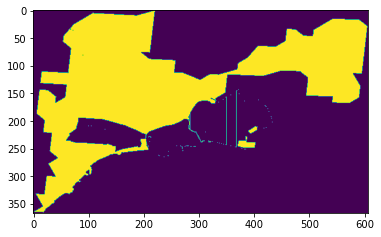

In [34]:
mask_three_t=cubes['ML'][1][0].copy()
mask_three_t[mask_three_t>=0]=1
mask_three_t[mask_three_t!=1]=0
mask_three=np.zeros(mask.shape)
mask_three[:mask_three_t.shape[0],:mask_three_t.shape[1]]=mask_three_t
mask-=mask_three
plt.imshow(mask)

In [35]:
#遍历点
ll=[]
coords=[]
for y in range(cube.shape[1]):
    for x in range(cube.shape[2]):
        if mask[y,x]==0:
            pass
        else:
            ll.append([int(i) for i in list(cube[:,y,x])])
            coords.append([x,y])
ll=np.array(ll)
ll[ll==-1]=0
ll2=[list(ll[i]) for i in range(ll.shape[0])]
date=all_liveuamap[all_liveuamap['region']=='ML'].iloc[0]['img_dates']
date2=[date]*len(ll2)

In [36]:
# 生成对照组pd
from shapely.geometry import Point
gpeo=[Point([0,0])]*len(ll2)
nointervention_pd_MLoutthreeregion=gpd.GeoDataFrame.from_dict({'id':list(range(len(ll2))),
'time':[0]*len(ll2),
'timestamp':[0]*len(ll2),
'type':['none']*len(ll2),
'name':['none']*len(ll2),
'is_use':[1]*len(ll2),
'region':['ML']*len(ll2),
'lat':[0]*len(ll2),
'lon':[0]*len(ll2),
'patch_x':[i[0] for i in coords],
'patch_y':[i[1] for i in coords],
'geometry':gpeo,
'is_interv':[0]*len(ll2),
'MTCF-PtNet':to_str(ll2),
'img_dates':date2
})
    

In [37]:
nointervention_pd_MLoutthreeregion['id']=list(range(40975,40975+len(nointervention_pd_MLoutthreeregion)))	

In [38]:
nointervention_pd_MLoutthreeregion.to_file('/data4/liveuamap/U_did_mt_MLoutthreeregion.shp')

In [39]:
all_liveuamap=pd.concat([all_liveuamap,nointervention_pd_MLoutthreeregion],axis=0)

In [40]:
did_pd_list=[]
for i in tqdm(range(len(all_liveuamap))):
    s=all_liveuamap.iloc[i]
    # rs=[np.float(i) for i in s['MTCF-sm'].split('&')]
    rsc=[np.int(i) for i in s['MTCF-PtNet'].split('&')]
    x=[np.int(i) for i in [s['patch_x']]*len(s['MTCF-PtNet'].split('&'))]
    y=[np.int(i) for i in [s['patch_y']]*len(s['MTCF-PtNet'].split('&'))]
    regions=[cities.index(s['region'])]*len(rsc)
    events=[s['timestamp']]*len(rsc)
    ids=[s['id']]*len(rsc)
    intervs=[s['is_interv']]*len(rsc)

    ts=[to_timestamp(i) for i in s['img_dates'].split('&')]
    # if intervs[0]==0:
    #     res=[-99]*len(rsc)
    # else:
    #     res=get_res(events[0],ts)
    did_pd_list.append(pd.DataFrame.from_dict({'id':ids,
                                                'time':ts,
                                                'interv_time':events,
                                                # 'period_difference':res,
                                                # 'value':rs,
                                                'value_c':rsc,
                                                'is_interv':intervs,
                                                'region':regions,
                                                'x':x,
                                                'y':y
                                                }))
did_pd=pd.concat(did_pd_list)

100%|██████████| 116189/116189 [01:37<00:00, 1189.17it/s]


In [41]:
did_pd['interv_time']=[int(i) for i in list(did_pd['interv_time'])]
did_pd.to_stata('/data4/liveuamap/U_did_mt_All_valuec.dta')

In [2]:
import pandas as pd
a=pd.read_stata('/data4/liveuamap/S_did_mt_c4.dta')

In [9]:
import numpy as np
np.array(list(set(a[a['is_interv']==1]['interv_time']))).min()

1414185000

In [13]:
datetime.fromtimestamp(1414185000)

datetime.datetime(2014, 10, 25, 5, 10)

In [12]:
from datetime import datetime